# Проверка гипотез и построение доверительных интервалов

Проверка гипотез, используются непараметрические критерии: критерий Колмогорова-Смирнова о виде распределения, критерий знаков, критерий Пирсона, тест Вилкоксона. Построение доверительных интервалов Холла, Эфрона, t-перцентильного доверительного интервала. Бутстрап. 

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Критерий Колмогорова-Смирнова (одновыборочный и двувыборочный)
Киллер - это весёлая лагерная игра. Краткие правила игры:

- Игроки пишут свои имена на карточках и кладут их в шляпу
- Игроки рандомно вытаскивают карточки из шляпы 
- Полученное имя - имя жертвы
- Каждый игрок одновременно и убийца и жертва
- Чтобы убить другого игрока, надо оказаться с ним наедине и застрелить из пальца
- Жертва убитого становится новой жертвой игрока
- Побеждает тот, кто совершит наибольшее число убийств

На экономическом факультете было два раунда игры в киллера. Все убийства регистрировались в гугл-форме. В табличках `killer_time1.csv` и `killer_time2.csv` лежит время в часах, которое проходило между убийствами.

In [2]:
killer1 = pd.read_csv("killer_time1.csv").hours_between_kill.values
killer2 = pd.read_csv("killer_time2.csv").hours_between_kill.values

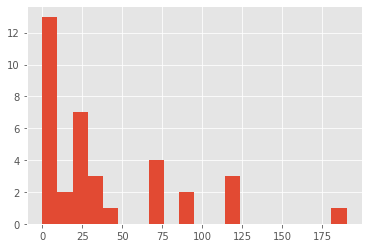

In [3]:
plt.hist(killer1, bins=20);

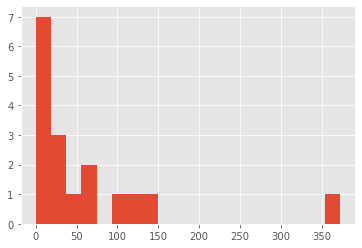

In [4]:
plt.hist(killer2, bins=20);

Распределение выглядит как экспоненциальное. Более того, по гистограммам возникает ощущение, что это одинаковое распределение. С помощью теста Колмогорова-Смирнова проверим гипотезу о том, что обе выборки пришли из одного и того же распределения. 

In [5]:
pvalue1 = sts.ks_2samp(killer1, killer2).pvalue
pvalue1

0.5452509816793374

Гипотеза о том, что выборки пришли из одного и того же распределения, не отвергается.

С помощью теста Колмогорова проверим гипотезу о том, что время для первой игры имеет экспоненциальное распределение с параметром $\lambda = 0.026$ 

In [6]:
pvalue2 = sts.kstest(killer1, 'expon', args=(0, 1/0.026)).pvalue
pvalue2

0.05735295335823968

Гипотеза не отвергается на уровне значимости 5%

## Критерий знаков, тест Вилкоксона, асимптотический тест 

$16$ лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. С целью установить, есть ли у мышей какие-то предпочтения насчет зеркал, измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

![](https://ars.els-cdn.com/content/image/1-s2.0-S0168159104000061-gr1.gif)

В файле `mouses_mirror.txt` лежит информация о том, какую долю времени мышка проводила в клетке с зеркалом. 

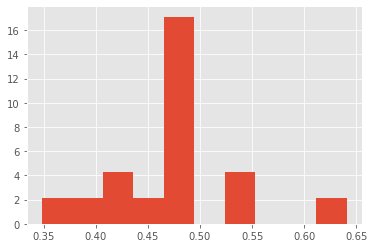

In [8]:
x = pd.read_csv('mouses_mirror.txt', header = None)[0].values
plt.hist(x, density=True);

Проверим гипотезу о том, что мышкам безразлично в какой комнате проводить время, с помощью __критерия знаков__. 

__Нулевая гипотеза__: медиана доли времени, проведенного в комнате с зеркалом, равна 0.5 (то есть половина наблюдений показывает, что мышка провела в комнате с зеркалом больше половины времени, половина наблюдений показывает, что мышка провела с зеркалом меньше половины времени). __Особенности теста:__ критерий знаков игнорирует величину изменений и обращает внимание только на их направление. 

In [9]:
from statsmodels.stats.descriptivestats import sign_test
_, pvalue_1 = sign_test(x, mu0=0.5)
pvalue_1

0.021270751953125

Проверим гипотезу о том, что мышкам безразлично в какой комнате проводить время, с помощью __теста Вилкоксона__.

In [10]:
from statsmodels.stats.descriptivestats import sign_test
_, pvalue_2 = sts.wilcoxon(x - 0.5)
pvalue_2

0.08793560714236243

__Особенности теста__: предполагаем, что наблюдение независимо одинаково распределены, их распределение симметрично относительно медианы. 

Проверим гипотезу о том, что мышкам безразлично в какой комнате проводить время, с помощью __асимптотического $z$-теста__.

In [11]:
from statsmodels.stats.weightstats import ztest,zconfint

_, pvalue_3 = ztest(x, value=0.5)
pvalue_3, x.mean()

(0.1346072107820589, 0.47528889375000005)

__Особенности теста__: предполагаем, что наблюдение независимо одинаково распределены, предполагаем, что у нас много наблюдений без аномалий

У теста Вилкоксона есть предположение, что выборка симметрична относительно медианы, а для асимптотического z-теста требуется наличие большого количества наблюдений без аномалий. Мы закрыли глаза на эти предпосылки, хотя в данном случае не могли этого делать (наше распределение не обязателньо симметрично и у нас в распоряжении не так много наблюдений)

> __Вывод:__ больше всего в данном случае стоит доверять критерию знаков, либо более подробно анализировать данные на соответствие предпосылкам, необходимым для применения других тестов. Гипотеза о безразличии мышей к зеркалу отвергается на 5% уровне значимости (но не отвергатся на 1% значимости). 

Подробнее про опыт с мышками [в оригинальном исследовании.](https://www.sciencedirect.com/science/article/abs/pii/S0168159104000061)

## Критерий Пирсона

Исследовательница Глафира считает, что любовь к энергетическим напиткам и успешность сдачи экзамена по математической статистике должны быть как-то связаны. Опросив $200$ своих однокурсников, она получила следующие результаты:

- Сдал, пьёт энергетик: 20
- Сдал, не пьёт энергетик: 120
- Завалил, пьёт энергетик: 40
- Завалил, не пьёт энергетик: 20

Правда ли, что энергетик оказывает на успешность сдачи экзамена какое-то влияние? Проверим гипотезу с помощью __критерия Пирсона__.

In [13]:
M = pd.DataFrame([[20, 120],[40, 20]])
from scipy.stats import chi2_contingency
chi, pvalue, k, _ = chi2_contingency(M)
pvalue

4.5058575666472013e-13

Нулевая гипотеза об отсутствии влияния энергетика на успешность сдачи отвергается.

## Проверка гипотезы о точности бомбардировки

В таблице `london_07-09-1940.tsv` лежат данные о бомбардировке Лондона 7 сентября 1940 года немецкой авиацией. Интересно выяснить, насколько прицельно велась бомбардировка. Если немецкие войска знали, где именно находятся британские военные объекты, они вели бы бомбардировку пристрельно.  

Ещё больше данных о бомбардировке Лондона: http://bombsight.org/data/sources/

In [3]:
df = pd.read_csv('london_07-09-1940.tsv', sep='\t')
print(df.shape)
df.head()

(751, 6)


,Time,Location,Type_of_bomb,Damage,x,y
0,0:08,"43 Southwark Park Road, SE16, London, UK",IB,Grocers: 3x2 roof damaged,-0.127660,51.507351
1,0:10,"49 Southwark Park road, Bermondsey, SE16, Lond...",IB,Bakers: 3x2 roof damaged,-0.054303,51.487794
2,0:15,"84 Southwark Park Road, SE16, London, UK",IB,front room on 1st floor and contents slightly ...,-0.127660,51.507351
3,0:18,"141 Braidwood Road, Catford SE6, London, UK",IB,10x6 roof damage,-0.025584,51.443299
4,0:20,"129 Killearn Road, Catford SE6, London, UK",IB,Front room on 1st floor severely damaged,-0.025584,51.443299


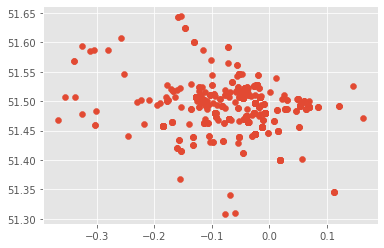

In [4]:
plt.scatter(df.x, df.y);

В колонках $x$ и $y$ лежат координаты точки, куда упала бомба. Разобьем Лондон решёткой размера $24 \times 24$ на $576$ небольших квадратных участков. С помощью функции `binned_statistic_2d` из пакета `scipy.stats`, подсчитаем как часто снаряд попадал на какой из участков. Информацию об этом в переменной `ret`. 

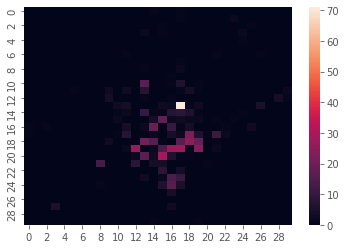

In [5]:
binx = np.linspace(df.x.min(), df.x.max(), 31)
biny = np.linspace(df.y.min(), df.y.max(), 31)

ret = sts.binned_statistic_2d(df.x.values, df.y.values, df.x.values, 'count', bins=[binx, biny])

sns.heatmap(ret.statistic);

Распакуем информацию о попаданиях в участки в вектор `z`. Нарисуем гистограмму для получившегося распределения. 

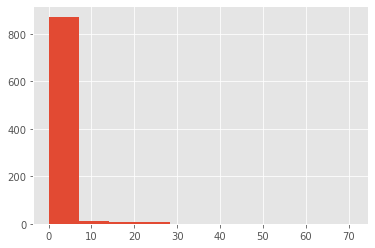

In [38]:
z = np.resize(ret.statistic,(1,30**2))[0]
plt.hist(z);

Участков много, а вероятность попадания на отдельный участок мала. При справедливости гипотезы о низкой точности стрельбы мы можем воспользоваться законом редких событий:

> Если в схеме испытаний Бернулли $p \to 0$, а $n \to \infty$, оно сходится к распределению Пуассона. 

Получается, что __при верности гипотезы о низкой точности стрельбы,__ число попаданий в квадрат имеет распределение Пуассона. Дополнительно будем предполагать, что попадания на разные участки независимы друг от друга. 

C помощью критерия Пирсона проверим гипотезу о том, что число попаданий на участок имеет распределение Пуассона. Прежде чем вычислять статистику, объединим все наблюдения из хвоста в одно. Хвостом будем считать все наблюдения после девятого. Получившуюся в результате расчётов статистику запишем в переменную `T`.

In [50]:
x, v = np.unique(z, return_counts=True) # значения и частоты
print(f'Количество попаданий в определенный квадрат: {x}', '\n'f'Частоты количества попаданий в определенный квадрат: {v}')

Количество попаданий в определенный квадрат: [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. 13. 14. 16. 17. 18. 19. 21.
 22. 24. 25. 27. 28. 29. 71.] 
Частоты количества попаданий в определенный квадрат: [774  45  20  11  12   3   5   3   3   3   1   1   2   2   3   1   2   1
   1   1   1   2   1   1   1]


In [51]:
# теоретические вероятности количества попаданий в определенный квадрат
from scipy.stats import poisson
p0 = []
for i in x:
    p0.append(poisson.pmf(k=i, mu=z.mean()))   
p0[:9]

[0.4341155897799043,
 0.3622453421385646,
 0.1511368066367011,
 0.04203842288302316,
 0.008769682106986214,
 0.001463562502743701,
 0.00020354359991861453,
 2.426368945061578e-05,
 2.5308376079739495e-06]

In [52]:
# количество квадратов
n = len(z)
n

900

In [53]:
# объединим последние наблюдения (количество попаданий 9 и больше) в одну группу
# тогда вектор вероятностей
p0 = p0[:9]
s = 1 - sum(p0)
p0.append(s)
p0 = np.array(p0)
p0

array([4.34115590e-01, 3.62245342e-01, 1.51136807e-01, 4.20384229e-02,
       8.76968211e-03, 1.46356250e-03, 2.03543600e-04, 2.42636895e-05,
       2.53083761e-06, 2.55825100e-07])

In [54]:
# тогда вектор частот
v = np.hstack((v[:9], v[9:].sum()))
v

array([774,  45,  20,  11,  12,   3,   5,   3,   3,  24], dtype=int64)

In [58]:
l = z.mean() # lambda
T = np.sum((v - n*p0)**2/(n*p0)) # статистика
from scipy.stats import chisquare
chisquare(v, n*p0)

Power_divergenceResult(statistic=2506879.799892361, pvalue=0.0)

> __Вывод:__ гипотеза о низкой точности отвергается (так как данные не имеют распределения Пуассона), следовательно, бомбардировка была прицельной

## Бутстрап

Компания Verizon - основная региональная телекоммуникационная компания в западной части США. Она отвечает за поддержание наземной телефонной связи (Incumbent Local Exchange Carrier, ILEC). Кроме того, она продаёт услуги междугородней связи, как и ряд её конкурентов, получивших название (Competing Local Exchange Carriers, CLEC).

Когда что-то шло не так, Verizon отвечала за ремонт своего оборудования и оборудования конкурентов. Она должна была делать ремонт оборудования конкурентов также быстро, как и ремонт своего оборудования. За этим следила комиссия по коммунальным услугам. 

Периодически возникали подозрения, что Verizon ремонтирует чужое оборудование медленнее. Комиссия сравнивала время ремонта для Verizon и других компаний. Чтобы определить есть ли нарушения, в каждом случае, она проверяла гипотезу о равенстве средних на уровне значимости $1\%$. 

Если более $1\%$ тестов оказывались значимыми, компания должна была бы заплатить высокий штраф. Гипотезы проверялись с помощью $t$-статистик. После консультации специалиста, Verizon предложила использовать тесты, робастные к выбросам и никак не завязанные на нормальность исходных распределений.

Построим доверительный интервал для разности медиан и посмотрим входит ли в него ноль. Будем использовать уровень значимости в $1\%$. Доверительный интервал будем строить для одной CLEC-комиании и для Verizon. 

In [21]:
df = pd.read_csv('verizon.txt', sep='\t')
print(df.shape)

# ILEC - Verizion
# CLEC - внешние клиенты 
df.head()

(1687, 2)


,Time,Group
0,17.50,ILEC
1,2.40,ILEC
2,0.00,ILEC
3,0.65,ILEC
4,22.23,ILEC


Посмотрим на то, как распределено время ремонта для разных компаний, а также на число наблюдений, которым мы располагаем. 

In [22]:
df.groupby('Group')['Time'].agg(['count', 'mean', 'median', 'std'])

,count,mean,median,std
Group,,,,
CLEC,23,16.509130,14.33,19.503576
ILEC,1664,8.411611,3.59,14.690039


В данных есть существенный перекос в количестве наблюдений. Среднее время ремонта CLEC почти вдвое больше, чем для ILEC. Вопрос в том, является ли это свидетельством дискриминации. Если посмотреть на распределение, можно заметить, что распределение времени на ремонт CLEC имеет как минимум один выброс. Тем не менее, если смотреть на медианы, которые робастны (нечувствительны) к выбросам, ситуация, связанная со временем, оказывается ещё более драмматичной. 

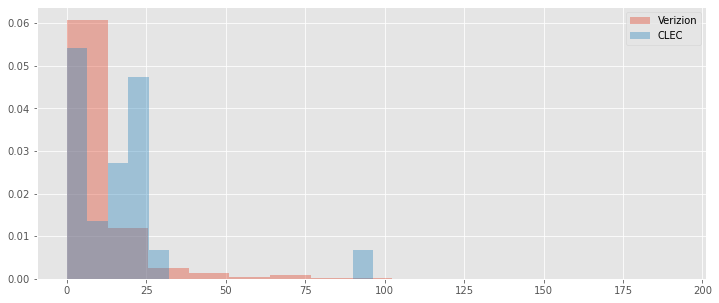

In [23]:
plt.figure(figsize=(12,5))
df[df.Group == 'ILEC'].Time.hist(bins=15, label='Verizion', alpha=0.4, density=True)
df[df.Group == 'CLEC'].Time.hist(bins=15, label='CLEC', alpha=0.4, density=True)
plt.legend();

Построим для разницы медиан $med_{CLEC} - med_{Verizion}$ __доверительный интервал Эфрона__ (перцентильный доверительный интервал). 

In [24]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

x = df[df.Group == 'CLEC'].Time.values
y = df[df.Group == 'ILEC'].Time.values

x_boot = get_bootstrap_sample(x, B_sample=10**5)
xb = np.median(x_boot, axis=0)

y_boot = get_bootstrap_sample(y, B_sample=10**5)
yb = np.median(y_boot, axis=0)

d = xb - yb

alpha = 0.01
left = np.quantile(d, alpha/2)
right = np.quantile(d, 1-alpha/2)
left, right

(1.73, 17.5)

Перцентильный интервал выглядит самым простым вариантом оценивания, но в реальности он даёт плохие результаты, так как сильно зависит от того, насколько хорошо изначальная выборка аппроксимирует истинное распределение случайной величины. В данной ситуации из-за того, что исходное распределение асимметрично, мы получаем смещение.

Построим для разницы медиан $med_{CLEC} - med_{Verizion}$ __доверительный интервал Холла__ (обратный перцентильный доверительный интервал). 

In [25]:
alpha = 0.01
theta_hat = np.median(x) - np.median(y)

d_h = d - theta_hat

left = theta_hat - np.quantile(d_h, 1-alpha/2)
right = theta_hat - np.quantile(d_h, alpha/2)
left, right

(3.9800000000000004, 19.75)

Построим __$t-$ перцентильный доверительный интервал:__

1. Найдем точечную оценку неизвестного параметра (разность медиан) и точечную оценку стандартного отклонения
2. Сгенерируем $10^5$ boostrap-выборок
3. Рассчитаем по каждой выбооке выборочную разницу медиан 
4. Рассчитаем по каждой выборке стандартную ошибку 
5. Найдем по каждой выборке $$t^* = \frac{\hat \theta^{*} - \hat{\theta}}{S^{*}}$$
6. Найдем для $t^{*}$ квантили уровня $0.05$ и $0.995$
7. Построим доверительный интервал для разности медиан

В качестве $S^{*}$ исполизуем сумму стандартных отклонений, посчитанных по выборкам $x$ и $y$. __Конечно же, мы используем при таком подходе неправильное стандартное отклонение. При этом мы надеемся, что бутсрэп сам поправит нашу ошибку. При таком подходе главное, чтобы знаменатель сходился по вероятности к пределу__.

In [26]:
alpha = 0.01
theta_hat = np.median(x) - np.median(y)
std_hat = np.std(x) + np.std(y)

d = xb - yb
sb = x_boot.std(axis=0) + y_boot.std(axis=0)

d = (d - theta_hat)/sb

left = theta_hat - np.quantile(d, 1-alpha/2)*std_hat
right = theta_hat - np.quantile(d, alpha/2)*std_hat
print('t-percentile:', left, right)

t-percentile: 1.8517899775500855 24.079047619925195


У $t$-bootstrap есть свойство: он "уважает" асимметрию распределений при расчёте доверительных интервалов. 

> __Вывод:__ ноль не входит ни в один доверителный интервал. Это говорит о том, что есть смещение во времени ремонта, оборудование конкурентов действительно ремонтируется дольше, чем оборудование компании

## Коэффициент ассиметрии и бутстрап

Коэффициент асимметрии (skewness) говорит нам о скошенности распределения. В финансах, как правило, люди хотят положительной асимметрии, поскольку это означает, что большие положительные доходы вытянуты в хвост и с какой-то небольшой вероятностью могут быть очень большими. При этом, отрицательные доходы более тесно сгруппированы и предсказуемы.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Relationship_between_mean_and_median_under_different_skewness.png/868px-Relationship_between_mean_and_median_under_different_skewness.png" width="600"> 
</center>

Подгрузим данные о стоимости акций Яндекса в течение последних $10$ лет. Перейдем от цен к доходностям. Найдем значение асимметрии доходности акций Яндекса. Запишем получившееся значение в переменную `sk`.

In [28]:
df = pd.read_csv('ynd.tsv', sep='\t')
df['fielddate'] = pd.to_datetime(df['fielddate'])
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(2291, 6)


,open,high,low,close,volume,adjusted
fielddate,,,,,,
2011-05-24,35.000000,42.009998,30.549999,38.840000,70186700.0,38.840000
2011-05-25,37.750000,37.900002,34.400002,35.000000,11761600.0,35.000000
2011-05-26,34.450001,35.450001,34.000000,34.770000,4417500.0,34.770000
2011-05-27,34.750000,35.000000,34.000000,34.450001,2006000.0,34.450001
2011-05-31,34.950001,35.369999,32.610001,33.450001,3981100.0,33.450001


In [29]:
from scipy.stats import skew
r = (df.close.diff()/df.close.shift(1)).dropna()
r = r.values
sk = skew(r)
sk

-0.15308974700747538

Отрицательные доходы вытянуты в хвост и с какой-то небольшой вероятностью могут быть очень большими. Это не очень хорошо для инвестора. Более того, отрицательные доходы менее предсказуемые

Будем считать, что доходности акций независимы друг от друга. Проверим с помощью бустрапа гипотезу о том, что коэффициент асимметрии равен нулю. Для этого: 

1. Сгенерируем $10^4$ бустрап-выборок
2. Найдем бутстрап-распределение статистики $$\delta = \frac{\hat{skew} - skew}{S}$$ Для этого $B$ раз сбустрапируем выборку и по каждой из них найдем $$\delta^{*} = \frac{\hat{skew^{*}} - \hat{skew}}{S^{*}},$$ где  $\hat{skew^{*}}$ - асимметрия, посчитанная по бустрап-выборке, $\hat{skew}$ - асимметрия исходной выборки, $S^{*}$ - стандартное отклонение, рассчитанное по бустрап-выборке
3. Посчитаем наблюдаемое значение статистики $$\delta_{obs} = \frac{\hat{skew} - 0}{S},$$  где $S$ - стандартное отклонение исходной выборки
4. Из бустрап распределения найдем критические значения статистики, при условии что гипотеза проверяется на уровне значимости $5\%$ против двусторонней альтернативы. 
5. Сравним эти значения и сделаем вывод.

In [30]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample
    
r_boot = get_bootstrap_sample(r, B_sample=10**4)
r_boot.shape

s_boot = skew(r_boot, axis=0)
skew_std = np.std(r_boot, axis=0)

# интервал Холла
alpha = 0.05
theta_hat = skew(r)
d = (s_boot - theta_hat)
left = theta_hat - np.quantile(d, 1-alpha/2)
right = theta_hat - np.quantile(d, alpha/2)
print('Hall: ', left, right)

# t-процентильный интервал
alpha = 0.05
theta_hat = skew(r)
std_hat = np.std(r)
d = (s_boot - theta_hat)/skew_std

left = theta_hat - np.quantile(d, 1-alpha/2)*std_hat
right = theta_hat - np.quantile(d, alpha/2)*std_hat
print('t-percentile:', left, right)

d_obs = (theta_hat - 0)/std_hat
d_crR = np.quantile(d, 1-alpha/2)
d_crL = np.quantile(d, alpha/2)
d_obs, d_crL, d_crR

Hall:  -0.5453233682506424 0.23059051770852998
t-percentile: -0.5479921375896345 0.22795732916375352


(-5.406525076422375, -13.457077386878034, 13.94639235583381)

С помощью получившегося бустрап-распределения и найденной наблюдаемой статистики $d$ оценим $p-$значение.

In [32]:
pvalue = 2*np.mean(d <= d_obs)
pvalue

0.444

Гипотеза о нулевом коэффициенте ассиметрии не отвергается, значит, заработать на бирже с помощью данных акций особо не получится. В среднем мы скорее всего будем выходить в  ноль.